

# Object detection with Intel® Distribution of OpenVINO™ toolkit

This tutorial uses a Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model to walk you through the basic steps of using two key components of the Intel® Distribution of OpenVINO™ toolkit: Model Optimizer and Inference Engine.

Model Optimizer is a cross-platform command-line tool that takes pre-trained deep learning models and optimizes them for performance/space using conservative topology transformations. It performs static model analysis and adjusts deep learning models for optimal execution on end-point target devices.

Inference is the process of using a trained neural network to interpret data such as images. This lab feeds a short video of cars, frame-by-frame, to the Inference Engine which subsequently utilizes an optimized trained neural network to detect cars.




## Step 0: Set Up

### 0.1: Import Dependicies

Execute the following cell to import Python dependencies needed for displaying the results in this notebook (tip: select the cell and use Ctrl+Enter to execute the cell)


In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
sys.path.insert(0,os.path.join(os.environ['HOME'],'Reference-samples/iot-devcloud/demoTools/'))
from demoutils import *
from openvino.inference_engine import IEPlugin, IENetwork
import cv2

### 0.2 Build the OpenVINO Samples

Execute the following cell to build the samples.

In [2]:
! /opt/intel/openvino/deployment_tools/inference_engine/samples/build_samples.sh

-- Looking for C++ include unistd.h
-- Looking for C++ include unistd.h - found
-- Looking for C++ include stdint.h
-- Looking for C++ include stdint.h - found
-- Looking for C++ include sys/types.h
-- Looking for C++ include sys/types.h - found
-- Looking for C++ include fnmatch.h
-- Looking for C++ include fnmatch.h - found
-- Looking for C++ include stddef.h
-- Looking for C++ include stddef.h - found
-- Check size of uint32_t
-- Check size of uint32_t - done
-- Looking for strtoll
-- Looking for strtoll - found
-- Found InferenceEngine: /opt/intel/openvino_2019.1.094/deployment_tools/inference_engine/lib/intel64/libinference_engine.so (Required is at least version "1.6") 
-- Performing Test HAVE_CPUID_INFO
-- Performing Test HAVE_CPUID_INFO - Success
-- Host CPU features:
--   3DNOW not supported
--   3DNOWEXT not supported
--   ABM not supported
--   ADX supported
--   AES supported
--   AVX supported
--   AVX2 supported
--   AVX512CD supported
--   AVX512F supported
--   AVX512ER

### 0.3 Run model downloader script to download example deep learning models

In [3]:
! python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd,ssd300,ssd512,squeezenet1.1,face-detection-retail-0004,face-detection-retail-0004-fp16,age-gender-recognition-retail-0013,age-gender-recognition-retail-0013-fp16,head-pose-estimation-adas-0001,head-pose-estimation-adas-0001-fp16,emotions-recognition-retail-0003,emotions-recognition-retail-0003-fp16,facial-landmarks-35-adas-0002,facial-landmarks-35-adas-0002-fp16


###############|| Downloading topologies ||###############

========= Downloading /home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt
... 100%, 28 KB, 60595 KB/s, 0 seconds passed

========= Downloading /home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22457 KB/s, 1 seconds passed

========= Downloading /home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/ssd/300/caffe/ssd300.prototxt
========= Downloading /home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/ssd/300/caffe/ssd300.caffemodel
... 100%, 95497 KB, 26735 KB/s, 3 seconds passed

========= Downloading /home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/ssd/512/caffe/ssd512.prototxt
==


    
## Step 1: Optimize a deep-learning model using the Model Optimizer (MO)

In this section, you will use the Model Optimizer to convert a trained model to two Intermediate Representation (IR) files (one .bin and one .xml). The Inference Engine requires this model conversion so that it can use the IR as input and achieve optimum performance on Intel hardware.


### 1.1 Create a directory to store IR files

In [4]:
! mkdir -p $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP32 
! mkdir -p $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP16


   
### 1.2 Run the Model Optimizer on the pretrained Caffe* model. This step generates one .xml file and one .bin file and places both files in the tutorial samples directory (located here: /object-detection/)

In [5]:
! python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_caffe.py --input_model $HOME/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP32 --scale 256 --mean_values [127,127,127]! 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28679/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]!
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimization: 	True
	- Path to the Input prototxt: 	/home/u28679/Referenc

In [6]:
! cd /opt/intel/openvino/deployment_tools/model_optimizer && python3 mo_caffe.py --input_model $HOME/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP16 --scale 256 --mean_values [127,127,127] --data_type FP16


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28679/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimization: 	True
	- Path to the Input prototxt: 	/home/u28679/Reference



   Note: Although this tutorial uses Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model, the Inference Engine is compatible with other neural network architectures, such as AlexNet*, GoogleNet*, MxNet* etc.


The Model Optimizer converts a pretrained Caffe* model to make it compatible with the Intel Inference Engine and optimizes it for Intel® architecture. These are the files you would include with your C++ application to apply inference to visual data.

   Note: If you continue to train or make changes to the Caffe* model, you would then need to re-run the Model Optimizer on the updated model.

### 1.3 Navigate to the tutorial sample model directory and verify creation of the optimized model files (the IR files)

In [7]:
! cd $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP32 && ls

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml


In [8]:
! cd $HOME/Reference-samples/smart-video-workshop/object-detection/mobilenet-ssd/FP16 && ls

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml



### Source your environmental variables

In [9]:
! /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized



    
####  Download the test video file to the object-detection folder.



Execute the following cell to download the test video file 

In [10]:
! wget 'https://pixabay.com/en/videos/download/video-1900_source.mp4' -P $HOME/Reference-samples/smart-video-workshop/object-detection/Python/ 

--2019-07-31 02:48:53--  https://pixabay.com/en/videos/download/video-1900_source.mp4
Resolving pixabay.com (pixabay.com)... 104.18.141.87, 104.18.82.97, 2606:4700::6812:8d57, ...
Connecting to pixabay.com (pixabay.com)|104.18.141.87|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /videos/download/video-1900_source.mp4 [following]
--2019-07-31 02:48:53--  https://pixabay.com/videos/download/video-1900_source.mp4
Reusing existing connection to pixabay.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://player.vimeo.com/play/465539722?s=151662242_1564603862_17bfd4e016f887474843f09977d21f5c&loc=external&context=Vimeo%5CController%5CApi%5CResources%5CVideoController.&download=1&filename=Cars%2B-%2B1900source.mp4 [following]
--2019-07-31 02:48:53--  https://player.vimeo.com/play/465539722?s=151662242_1564603862_17bfd4e016f887474843f09977d21f5c&loc=external&context=Vimeo%5CController%5CApi%5CResources%5CVideoController.&down

In [11]:
! mv video-1900_source.mp4  cars_1900.mp4

###  Input Video

Execute the following cell to create a symlink and view the input video.

In [12]:
!ln -sf $HOME/Reference-samples/smart-video-workshop/object-detection/Python/cars_1900.mp4 
videoHTML('Cars video', ['cars_1900.mp4'])

ln: '/home/u28679/Reference-samples/smart-video-workshop/object-detection/Python/cars_1900.mp4' and './cars_1900.mp4' are the same file


## Step 3: Inference on a video

The Python code takes in command line arguments for video, model and so on.

**Command line arguments options and how they are interpreted in the application source code**

```
SAMPLEPATH=$PBS_O_WORKDIR
python3 tutorial1.py -m ${SAMPLEPATH}/../mobilenet-ssd/$3/mobilenet-ssd.xml \
                -i ${INPUT_FILE} \
                -o ${RESULTS_PATH} \
                -d ${DEVICE} \
                -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so

```
##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the **mobilenet-ssd** pre-trained model which has been pre-processed using the **model optimizer**.
   There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
   (**Note** we are using mobilenet-ssd in this example. However, OpenVINO's Inference Engine is compatible with other neural network architectures such as AlexNet*, GoogleNet*, SqueezeNet* etc.,) 
* -i  location of the input video stream
* -o location where the output file with inference needs to be stored (results/[device])
* -d type of Hardware Acceleration (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* -l absolute path to the shared library and is currently optimized for core/xeon (/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_sse4.so)

### 3.1: Create a Job File

All the code up to this point has been executed within the Jupyter Notebook instance running on a development node based on an Intel® Xeon® Scalable Processor, where the Notebook is allocated to a single core. To run inference on the entire video, you need more compute power. Run the workload on several DevCloud's edge compute nodes and then send work to the edge compute nodes by submitting jobs into a queue. For each job, specify the type of the edge compute server that must be allocated for the job.

To pass the specific variables to the Python code, we use the following arguments:

* `-m`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the optimized **MobileNet-SSD** model's XML
* `-i`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;location of the input video
* `-o`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;output directory
* `-d`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hardware device type (CPU, GPU, MYRIAD)
* `-l`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;path to the CPU extension library

The job file will be executed directly on the edge compute node.

In [13]:
%%writefile tutorial1_job.sh
ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR
DEVICE=$2
FP_MODEL=$3
INPUT_FILE=$4
RESULTS_BASE=$1


NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
! python3 tutorial1.py  -m ${SAMPLEPATH}/../mobilenet-ssd/${FP_MODEL}/${NN_MODEL} \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -l /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so

Overwriting tutorial1_job.sh


### 3.2: Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit people_counter to several different types of edge compute nodes simultaneously or just one node at a time.

There are three options of `qsub` command that we use for this:
- `-l` : this option let us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option let us send arguments to the bash script. 
- `-N` : this option let us name the job so that it is easier to distinguish between them.

The `-F` flag is used to pass arguments to the job script.
The [tutorial1_job.sh](tutorial1_job.sh) takes in 4 arguments:
1. the path to the directory for the output video and performance stats
2. targeted device (e.g. CPU, GPU and MYRIAD.
3. the floating precision to use for inference
4. location of the input video stream

The job scheduler uses the contents of `-F` flag as the argument to the job script.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [14]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     35 idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,1gbe
     15 idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     18 idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     23 idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
     10 idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     16 idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     15 idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1 idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1gbe
      1 idc010jal,compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe


Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

**Note**: If you want to use your own video, change the environment variable 'VIDEO' in the following cell from "cars_1900.mp4" to the full path of your uploaded video.

In [15]:
os.environ["VIDEO"] = 'cars_1900.mp4'

### 3.3: Job queue submission

Each of the cells below will submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all jobs at once or follow one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, submit a job to <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on the CPU.

In [16]:
#Submit job to the queue
job_id_core = !qsub tutorial1_job.sh -l nodes=1:idc001skl:i5-6500te -F "results/Core CPU FP32 $VIDEO " -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)

38638.c003


***Wait!***

Please wait for 1-2 minutes after running the above cell for inferencing.

####  Execute the ROIViewer Sample

For simplicity of the code and to put more focus on the performance number, video rendering with rectangle boxes for detected objects has been separated from tutorial1.py


In [17]:
! python3 ROIviewer.py -i $HOME/Reference-samples/smart-video-workshop/object-detection/Python/cars_1900.mp4  -l $HOME/Reference-samples/smart-video-workshop/object-detection/pascal_voc_classes.txt -o results/Core 

#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the following cell, we submit a job to <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [18]:
#Submit job to the queue
job_id_gpu = !qsub tutorial1_job.sh -l nodes=1:idc001skl:intel-hd-530 -F " results/GPU GPU FP32 $VIDEO" -N obj_det_gpu 
print(job_id_gpu[0])
#Progress indicators
if job_id_gpu:
    progressIndicator('results/GPU', 'i_progress.txt', "Inference", 0, 100)

38639.c003


***Wait!***


Please wait for 1-2 minutes after running the above cell for inferencing.

####  Execute the ROIViewer Sample

For simplicity of the code and to put more focus on the performance number, video rendering with rectangle boxes for detected objects has been separated from tutorial1.py

In [19]:
! python3 ROIviewer.py -i $HOME/Reference-samples/smart-video-workshop/object-detection/Python/cars_1900.mp4  -l $HOME/Reference-samples/smart-video-workshop/object-detection/pascal_voc_classes.txt -o results/GPU 

#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the following cell, we submit a job to <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [20]:
#Submit job to the queue
job_id_ncs2 = !qsub tutorial1_job.sh -l nodes=1:idc004nc2:intel-ncs2 -F "results/NCS2 MYRIAD FP16 $VIDEO " -N obj_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/NCS2', 'i_progress.txt', "Inference", 0, 100)

38640.c003


***Wait!***


Please wait for 1-2 minutes after running the above cell for inferencing.

#### Execute the ROIViewer Sample

For simplicity of the code and to put more focus on the performance number, video rendering with rectangle boxes for detected objects has been separated from tutorial1.py

In [21]:
! python3 ROIviewer.py -i $HOME/Reference-samples/smart-video-workshop/object-detection/Python/cars_1900.mp4  -l $HOME/Reference-samples/smart-video-workshop/object-detection/pascal_voc_classes.txt -o results/NCS2

### 3.4 Check the Progress

Check the progress of the jobs. `Q` status stands for `queued`, `R` for `running`. How long a job is being queued is dependent on number of the users. It should take up to 5 minutes for a job to run. If the job is no longer listed, it's done. 

In [22]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs you have submitted (referenced by `Job ID` that gets displayed right after you submit the job in step 3.3).
There should also be an extra job in the queue "jupyterhub": this job runs your current Jupyter Notebook session.

The 'S' column shows the current status. 
- If it is in Q state, it is in the queue waiting for available resources. 
- If it is in R state, it is running. 
- If the job is no longer listed, it means it is completed.

**Note**: Time spent in the queue depends on the number of users accessing the edge nodes. Once these jobs begin to run, they should take from 1 to 5 minutes to complete.

Here are the parameters used in the above cells to run the application:

In [23]:
! python3 tutorial1.py -h

usage: tutorial1.py [-h] -m MODEL -i INPUT [-l CPU_EXTENSION] [-pp PLUGIN_DIR]
                    [-d DEVICE] [--labels LABELS] [-pt PROB_THRESHOLD]
                    [-fr FR] [-b B] -o OUTPUT_DIR

optional arguments:
  -h, --help            show this help message and exit
  -m MODEL, --model MODEL
                        Path to an .xml file with a trained model.
  -i INPUT, --input INPUT
                        Path to video file or image. 'cam' for capturing video
                        stream from camera
  -l CPU_EXTENSION, --cpu_extension CPU_EXTENSION
                        MKLDNN (CPU)-targeted custom layers.Absolute path to a
                        shared library with the kernels impl.
  -pp PLUGIN_DIR, --plugin_dir PLUGIN_DIR
                        Path to a plugin folder
  -d DEVICE, --device DEVICE
                        Specify the target device to infer on; CPU, GPU, FPGA
                        or MYRIAD is acceptable. Demo will look for a suitable
               

In [24]:
! python3 ROIviewer.py -h

usage: ROIviewer.py [-h] -i INPUT -l LABELS [--ROIfile ROIFILE] [-b B] -o
                    OUTPUT_DIR

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Path to video file or image. 'cam' for capturing video
                        stream from camera
  -l LABELS, --labels LABELS
                        Labels mapping file
  --ROIfile ROIFILE     Path to ROI file.
  -b B                  Batch size
  -o OUTPUT_DIR, --output_dir OUTPUT_DIR
                        Location to store the results of the processing




## Step 4: View Results

Once the jobs are completed, the queue system outputs the `stdout` and `stderr` streams of each job into files with names
`obj_det_{type}.o{JobID}` and `obj_det_{type}.e{JobID}`. Here, obj_det_{type} corresponds to the `-N` option of qsub. For example, `core` for Core CPU target.

You can find the output video files inside the `results` directory. We wrote a short utility script that will display these videos within the notebook. See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook. 

`obj_det_{type}.e{JobID}`

(here, obj_det_{type} corresponds to the `-N` option of qsub).

However, for this case, we may be more interested in the output video files. They are stored in mp4 format inside the `results/` directory.
We wrote a short utility script that will display these videos with in the notebook.
Run the cells below to display them.
See `demoutils.py` if you are interested in understanding further how the results are displayed in notebook.

In [25]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/Core/cars_output.mp4'], 
          'results/Core/stats.txt')

In [26]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/GPU/cars_output.mp4'], 
          'results/GPU/stats.txt')

In [27]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
           ['results/NCS2/cars_output.mp4'], 
          'results/NCS2/stats.txt')

## Step 5: Performance Comparison

The running time of each inference task is recorded in `stats_*job_id*_*architectute*.txt` in `results` folder, where the *architecture* corresponds to the architecture of the target edge compute node. Run the cell below to plot the results of all jobs side-by-side. Lower values for processing time mean better performance. Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

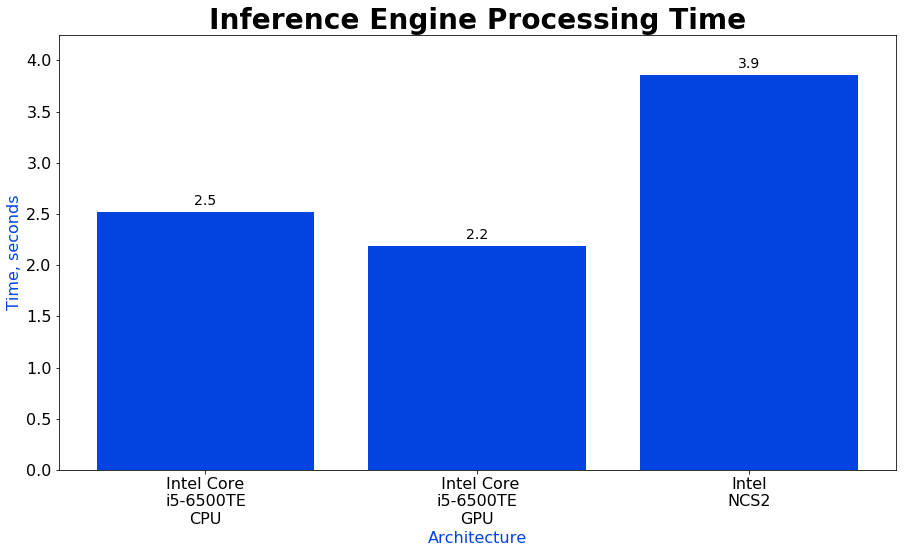

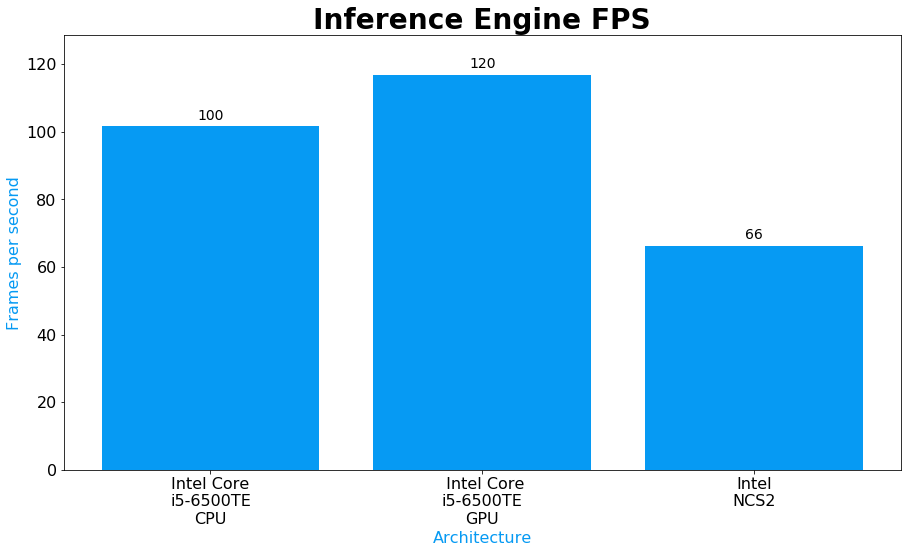

In [28]:
 arch_list = [('core', 'Core', 'Intel Core\ni5-6500TE\nCPU'),
             ('gpu', 'GPU', ' Intel Core\ni5-6500TE\nGPU'),
             ('ncs2', 'NCS2', 'Intel\nNCS2')]

stats_list = []
for arch, dir_,  a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/{}/stats.txt'.format(dir_), a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )